In [ ]:
%pip install sentencepiece

In [45]:
import codecs
from collections import defaultdict, namedtuple, Counter
import os
import dill
from operator import add
from functools import reduce
import itertools
import re

from typing import List, Union, Dict, Optional

from accelerate import Accelerator
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as linalg
import sklearn.manifold as manifold
import sklearn.cluster as cluster
import sklearn.neighbors as neighbors
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import transformers

ReferenceEncoding = namedtuple("ReferenceEncoding", ["reference", "output", "encoding"])

In [46]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast, MBart50Tokenizer

mbart_model = "facebook/mbart-large-50-many-to-many-mmt"
model_path = "mbart_finetuned50"

model = MBartForConditionalGeneration.from_pretrained(model_path)
tokenizer = MBart50TokenizerFast.from_pretrained(mbart_model, src_lang="de_DE", tgt_lang="en_XX")

In [47]:
# Read in data
DATA_DIR = "./data/wmt19/ende"

# Proof of concept: Clustering

In [48]:
references = defaultdict(list)

for ref_path in os.listdir(DATA_DIR):
    with codecs.open(os.path.join(DATA_DIR, ref_path), "rb", "utf-8") as ref_file:
        for i, line in enumerate(ref_file.readlines()):
            references[i].append(line.strip())

In [142]:
references

defaultdict(list,
            {0: ['Abgeordnete walisischen Ursprungs machen sich Sorgen, „wie Idioten auszusehen“',
              '<srcset setid="newstest2019" srclang="any">',
              'Walisische Abgeordnete befürchten als ,Idioten’ dazustehen.',
              'Walisische Abgeordnete befürchten als ,Idioten’ dazustehen.',
              'Abgeordnete aus Wales hatten Angst, das Bild von „Dummköpfen“ abzugeben.',
              'Walisische Abgeordnete befürchten als ,Idioten’ dazustehen.',
              'Abgeordnete walisischen Ursprungs machen sich Sorgen, „wie Idioten auszusehen“'],
             1: ['Der Vorschlag, den Namen der Versammlung in MWP (Mitglied des walisischen Parlaments) zu ändern, rief bei einigen ihrer Angehörigen Fassungslosigkeit hervor.',
              '<doc sysid="ref" docid="bbc.381790" genre="news" origlang="en">',
              'Bei einigen AMs herrscht Fassungslosigkeit über einen Vorschlag, ihr Titel solle in MWPs (Members of the Welsh Parliament) geänder

In [ ]:
def extract_latents(model, tokenizer, sentences):
    # Tokenize inputs and feed to model
    generation_config = transformers.GenerationConfig.from_pretrained(mbart_model)
    generation_config.decoder_hidden_states = True
    generation_config.return_dict_in_generate = True
    generation_config.num_beams = 1  # TODO: Debug
    #print(generation_config)
    
    tokenized_sequences = tokenizer(sentences, return_tensors="pt", padding=True)
    in_shape = tokenized_sequences["input_ids"].shape[0]
    
    outputs = model.generate(
        input_ids=tokenized_sequences["input_ids"], 
        attention_mask=tokenized_sequences["attention_mask"],
        output_hidden_states=True,
        forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"],
        generation_config=generation_config,
        return_dict_in_generate=True,
    )
    #print("Generated shape", outputs.sequences.shape)

    #decoded = tokenizer.batch_decode(outputs.sequences)
    #print(outputs.keys
    
    # Collect special tokens
    ignore_token_ids = (
        set(tokenizer.lang_code_to_id.values())
        | set (tokenizer.prefix_tokens)
        | set (tokenizer.suffix_tokens)
    )
    ignore_token_ids |= {
        tokenizer.bos_token_id, tokenizer.eos_token_id, tokenizer.sep_token_id, tokenizer.pad_token_id
    }
    # outputs.decoder_hidden_states has the following structure:
    # One tuple entry per time step
    # Inside that: 13 entries for every decoder layer
    # Inside the uppermost decoder layer: Shape [30, 1, 1024]
    # 30: batch size (?), 1: sequence length, 1024: Embedding size
    # batch size here is actual batch size x beam size
    
    decoder_states = outputs.decoder_hidden_states
    
    reference_encodings = defaultdict(list)
    
    for t in range(len(decoder_states)):
        hidden = decoder_states[t][-1]
        
        for b in range(hidden.shape[0]):
            token_id = outputs.sequences[b][t]
            
            if int(token_id.numpy()) in ignore_token_ids:
                continue
                
            encoding = hidden[b]
                
            reference_encodings[b].append(encoding)
            
    # Create object
    final_encodings = {}
    for ref_i, encoding in reference_encodings.items():
        output_ids = outputs.sequences[ref_i]
        output_ids = torch.LongTensor(
            list(filter(lambda token_id: token_id not in ignore_token_ids, list(output_ids.numpy())))
        )
        
        obj = ReferenceEncoding(
            reference=sentences[ref_i],
            output=output_ids,
            encoding=encoding,
        )
        final_encodings[ref_i] = obj
    
    
    return final_encodings

In [ ]:
ENCODING_PATH = "ref_encodings10.pickle"

def generate_or_load_encodings(encoding_path, limit=np.inf):
    if not os.path.exists(encoding_path):
        all_encodings = {}

        for i in tqdm(references.keys()):

            if i > limit:
                break

            all_encodings[i] = extract_latents(model, tokenizer, references[i])

        with open(encoding_path, "wb") as encoding_file:
            pickle.dump(all_encodings, encoding_file)

    else:
        with open(encoding_path, "rb") as encoding_file:
            all_encodings = pickle.load(encoding_file)
            
    return all_encodings

In [ ]:
reference_encodings = generate_or_load_encodings(ENCODING_PATH, 10)

reference_encodings

In [ ]:
def fit_projection(reference_encodings):
    # Fit dimensionality reductions 
    X = []
    
    for ref_encodings in reference_encodings.values():
        for encodings in ref_encodings.values():
            X += encodings.encoding
            
    # Flatten list
    X = torch.concatenate(X, dim=0).numpy()
    
    # Fit transformation
    tsne = manifold.TSNE()
    tsne.fit(X)
    
    return tsne

In [ ]:
tsne = fit_projection(reference_encodings)

In [ ]:
def plot_encodings(reference_encodings, projection, cluster_assignments=None):
    
    total_i = 0
    
    if cluster_assignments is not None:
        markers = itertools.cycle(matplotlib.markers.MarkerStyle.markers.keys()) 
        cluster2marker = {
            cluster: next(markers)
            for cluster in range(-1, max(cluster_assignments) + 1)
        }
    
    
    with tqdm(total=len(reference_encodings) * len(reference_encodings[0])) as pbar:
        for sentence_idx, encodings in reference_encodings.items():
            color = np.abs(np.random.rand(3))
            color /= color.sum() * 0.8
            
            for ref_idx, encs in encodings.items():

                for i, enc in enumerate(encs.encoding):
                    alpha_discount = i / len(encs.encoding)

                    projected_enc = projection.embedding_[total_i]
                    enc_x, enc_y = tuple(projected_enc)
                    
                    marker = None
                    if cluster_assignments is not None:
                        marker = cluster2marker[cluster_assignments[total_i]]
                        

                    plt.scatter(enc_x, enc_y, alpha=1 - alpha_discount, c=color, marker=marker)

                    total_i += 1
                
                pbar.update(1)
                
    plt.tight_layout()
    plt.show()
        

In [ ]:
plot_encodings(reference_encodings, tsne)

In [ ]:
def cluster_latents(reference_encodings, min_samples = 5):
    # Fit clustering
    X = []
    
    for ref_encodings in reference_encodings.values():
        for encodings in ref_encodings.values():
            X += encodings.encoding
            
    # Flatten list
    X = torch.concatenate(X, dim=0).numpy()
    clustering = cluster.OPTICS(min_samples=min_samples, n_jobs=-1, algorithm="ball_tree", leaf_size=100).fit(X)
    labels = clustering.labels_
    
    return labels

In [ ]:
labels = cluster_latents(reference_encodings)

In [ ]:
print(labels)

In [ ]:
plot_encodings(reference_encodings, tsne, labels)

In [ ]:
def find_cluster_contents(reference_encodings, labels, tokenizer):
    total_i = 0
    cluster_contents = defaultdict(list)
    
    for ref_encodings in reference_encodings.values():
        for ref_encoding in ref_encodings.values():
            token_ids = ref_encoding.output
            
            for i in range(len(token_ids)):
                tokens = tokenizer.decode(token_ids[:i+1], clean_up_tokenization_spaces=False)
                cluster_contents[labels[total_i]].append(tokens)
                
                total_i += 1
                
    return cluster_contents

In [ ]:
find_cluster_contents(reference_encodings, labels, tokenizer)

In [ ]:
def evaluate_cluster_purity(reference_encodings, labels):
    # Except for -1 (not belonging to any cluster), 
    # check how many of the cluster members actually belong to the same 
    # set of references
    cluster_to_sentence = defaultdict(list)
    total_i = 0
    
    for sentence_i, ref_encodings in reference_encodings.items():
        for ref_encoding in ref_encodings.values():
            for i in range(len(ref_encoding.output)):
                cluster = labels[total_i]
                cluster_to_sentence[cluster].append(sentence_i)
                total_i += 1
                
    del cluster_to_sentence[-1]
    
    avg_purity = 0
    
    for cluster, contents in cluster_to_sentence.items():
        freqs = Counter(contents)
        _, freq = max(freqs.items(), key=lambda tpl: tpl[1])
                
        avg_purity += freq / len(contents)
        
    return avg_purity / len(cluster_to_sentence)

In [ ]:
reference_encodings100 = generate_or_load_encodings("ref_encodings100.pickle", 100)

In [ ]:
LABEL100_PATH = "ref_labels100.pickle"  
    
if not os.path.exists(LABEL100_PATH):
    
    labels100 = cluster_latents(reference_encodings100)

    with open(LABEL100_PATH, "wb") as label_file:
        pickle.dump(labels100, label_file)

else:
    with open(LABEL100_PATH, "rb") as label_file:
        labels100 = pickle.load(label_file)

In [ ]:
evaluate_cluster_purity(reference_encodings, labels)

In [ ]:
evaluate_cluster_purity(reference_encodings100, labels100)

In [ ]:
def normalize_encodings(reference_encodings):
    reference_encodings = dict(reference_encodings)  # Create new object
    
    X = []
    
    for ref_encodings in reference_encodings.values():
        for encodings in ref_encodings.values():
            X += encodings.encoding
            
    # Flatten list
    X = torch.concatenate(X, dim=0)
    mean = torch.mean(X, dim=0).unsqueeze(0)
    std = torch.std(X, dim=0).unsqueeze(0)
    print(mean.shape)
    print(mean, std)
    
    for sentence_i, ref_encodings in reference_encodings.items():
        for ref_i, ref_encoding in ref_encodings.items():
            normed_encoding = []
            
            for enc in ref_encoding.encoding:
                normed_encoding.append((enc - mean) / std)
                
            reference_encodings[sentence_i][ref_i] = ReferenceEncoding(
                reference=ref_encoding.reference,
                output=ref_encoding.output,
                encoding=normed_encoding,
            )
            
            
    return reference_encodings

In [ ]:
normalized_reference_encodings100 = normalize_encodings(reference_encodings100)

In [ ]:
print(reference_encodings100[0][0])
print(normalized_reference_encodings100[0][0])

In [ ]:
find_cluster_contents(reference_encodings100, labels100, tokenizer)

## Trying it with unique references

In [ ]:
reference_encodings500 = generate_or_load_encodings("ref_encodings500.pickle", 500)

In [ ]:
filtered_reference_encodings500 = {
    sentence_id: {0: encoding_dict[0]}
    for sentence_id, encoding_dict in reference_encodings500.items()
}

In [ ]:
labels_filtered_encodings500 = cluster_latents(filtered_reference_encodings500)

In [ ]:
evaluate_cluster_purity(filtered_reference_encodings500, labels_filtered_encodings500)

In [ ]:
find_cluster_contents(filtered_reference_encodings500, labels_filtered_encodings500, tokenizer)

# Proof of concept: Clustering + Conformal Prediction

In [50]:
def create_gamma_cos(gamma=1):
    def gamma_cosine_distance(u, v, norm_u, norm_v, gamma=gamma):
        return (u @ v + 1 / gamma) / (norm_u * norm_v + 1 / gamma) * -1 + 1  # Cosine similarity
    
    return gamma_cosine_distance

In [51]:
def create_gamma_l2(gamma=1):
    def gamma_l2_distance(u, v, norm_u, norm_v, gamma=gamma):
        return (gamma * norm_u + norm_v - 2 * u @ v) / np.sqrt(u.shape[-1])
    
    return gamma_l2_distance

In [52]:
# TODO: Implement dimensionality reduction

class DataStore:
    
    # torch.float64
    def __init__(self, distance_metric=create_gamma_l2(), storage_dtype=torch.float64):
        self.latents = []
        self.norms = {}
        self.conformity_scores = []
        self.index_structure_class = neighbors.BallTree
        self.index_structure = None
        self.storage_dtype = storage_dtype
        self.distance_metric = distance_metric
        
    def add(self, encoding: torch.FloatTensor, conformity_score: float):
        encoding = encoding.to(self.storage_dtype)
        encoding_np = encoding.numpy()
        hash_encoding = hash(encoding_np.data.tobytes())
        
        self.norms[hash_encoding] = linalg.norm(encoding_np) ** 2
        
        self.latents.append(encoding)
        self.conformity_scores.append(conformity_score)
        
    def build(self, **indexing_kwargs):
        self.conformity_scores = np.array(self.conformity_scores)
        #self.predictions = np.stack(self.predictions, axis=0)
        latents = torch.stack(self.latents, dim=0).to(self.storage_dtype).numpy()
        
        del self.latents
        
        self.index_structure = self.index_structure_class(
            latents, 
            metric=self._custom_distance_wrapper(),
            **indexing_kwargs
        )
        
    def _custom_distance_wrapper(self):
        
        def custom_distance(u, v):
            hash_u, hash_v = hash(u.data.tobytes()), hash(v.data.tobytes())

            # Retrieve this from cache if available
            norm_u = self.norms.get(hash_u, linalg.norm(u) ** 2)
            norm_v = self.norms.get(hash_v, linalg.norm(v) ** 2)

            # Now we only have to compute the dot product
            # return (norm_u + norm_v - 2 * u @ v) / np.sqrt(u.shape[-1])
            return self.distance_metric(u, v, norm_u, norm_v)
        
        return custom_distance
        
    def find(self, query: torch.FloatTensor, top_k: int):
        assert self.index_structure is not None, "Index has not been built yet!"
        
        query = query.to(self.storage_dtype).numpy()
        distances, indices = self.index_structure.query(
            query, k=top_k, return_distance=True,
            dualtree=True,
            breadth_first=True
        )
        
        return distances, self.conformity_scores[indices]
        
    def save(self, path: str):
        with open(path, "wb") as data_file:
            dill.dump(self, data_file)  
        
    @staticmethod
    def load(path: str):
        with open(path, "rb") as data_file:
            data_store = dill.load(data_file)
            
        return data_store

### Inference Code: Building quantiles dynamically

In [53]:
def compute_quantile(query: torch.FloatTensor, data_store: DataStore, top_k: int, alpha: float, temperature: float = 1, scale_by_dist: bool = True):
    distances, conformity_scores = data_store.find(query, top_k)
    distances, conformity_scores = distances[0], conformity_scores[0]
    
    if scale_by_dist:
        distances = distances - np.min(distances)
        scale = np.exp(-distances / temperature)
        scale = scale / np.sum(scale)
        
        conformity_scores = np.random.choice(
            conformity_scores,
            size=len(conformity_scores),
            p=scale
        )
        
    q_level = np.ceil((top_k + 1) * (1 - alpha)) / top_k
    q_hat = np.quantile(conformity_scores, q_level, interpolation="higher")
    
    return q_hat

In [54]:
def get_prediction_set(output: torch.FloatTensor, quantile: float):
    classes = torch.arange(0, output.shape[-1])
    prediction_set = classes[output >= 1 - quantile]
    
    return prediction_set

### Evaluation Code

In [55]:
def plot_histogram(data: Dict[str, List[int]], xlabel: str, num_bins: int = 20, img_path: Optional[str] = None):

    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.grid(axis="both", which="major", linestyle=":", color="grey")
    
    for name, d in data.items():
        plt.hist(d, num_bins, alpha=0.65, label=name)
    
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    
    if img_path is not None:
        plt.savefig(img_path, dpi=300)
    
    plt.show()

In [56]:
def compute_coverage(prediction_sets: List[torch.LongTensor], labels: torch.LongTensor):
    coverages = list(map(
        lambda tpl: int(int(tpl[1].numpy()) in tpl[0]), 
        zip(prediction_sets, labels)
    ))
    
    return np.mean(coverages)

### Putting everything together

In [57]:
# Read targets and create a calibration and test set 
TARGET_FILE = "newstest2019-ende-src.en.sgm"

target_sentences = []

with open(os.path.join(DATA_DIR, TARGET_FILE), "r") as target_file:
    for line in target_file.readlines():
        
        if not line.startswith("<seg"):
            continue
            
        line = re.match(r'<seg id="\d+">(.+)</seg>', line).group(1).strip()
        target_sentences.append(line)
        print(line)

Welsh AMs worried about 'looking like muppets'
There is consternation among some AMs at a suggestion their title should change to MWPs (Member of the Welsh Parliament).
It has arisen because of plans to change the name of the assembly to the Welsh Parliament.
AMs across the political spectrum are worried it could invite ridicule.
One Labour AM said his group was concerned "it rhymes with Twp and Pwp."
For readers outside of Wales: In Welsh twp means daft and pwp means poo.
A Plaid AM said the group as a whole was "not happy" and has suggested alternatives.
A Welsh Conservative said his group was "open minded" about the name change, but noted it was a short verbal hop from MWP to Muppet.
In this context The Welsh letter w is pronounced similarly to the Yorkshire English pronunciation of the letter u.
The Assembly Commission, which is currently drafting legislation to introduce the name changes, said: "The final decision on any descriptors of what Assembly Members are called will of cour

In [58]:
cut_references = {
    key: val
    for key, val in references.items()
    if key < len(target_sentences)
}

In [59]:
assert len(target_sentences) == len(cut_references), f"{len(target_sentences)} is not {len(cut_references)}"

In [60]:
# Sample indices for calibration and some for test
test_percentage = 0.2
N = len(target_sentences)

np.random.seed(4356)
test_ids = set(np.random.choice(
    range(N), 
    size=int(test_percentage * N),
    replace=False
))
calibration_ids = set(range(N)) - test_ids

assert len(test_ids & calibration_ids) == 0

In [61]:
calibration_source = [references[id_][0] for id_ in calibration_ids]
calibration_target = [target_sentences[id_] for id_ in calibration_ids]
test_source = [references[id_][0] for id_ in test_ids]
test_target = [target_sentences[id_] for id_ in test_ids]

In [21]:
calibration_source = []
calibration_target = []
test_source = []
test_target = []

for id_ in calibration_ids:
    n = len(references[id_])
    calibration_source += references[id_]
    calibration_target += target_sentences[id_] * n 

In [ ]:
del calibration_source
del calibration_target

Fine-tune MBART for this dataset

In [62]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return self.encodings["input_ids"].shape[0]


def finetune_model(model, tokenizer, source_sentences, target_sentences, num_steps):
    i = 0
    
    accelerator = Accelerator()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001)
    
    inputs = SimpleDataset(tokenizer(
        source_sentences, text_target=target_sentences, 
        return_tensors="pt",
        padding=True,
    ))
    
    data_loader = DataLoader(inputs, batch_size=16)
    
    def batch_generator(train_split: DataLoader):
        while True:
            for batch in train_split:
                yield batch
                
    progress_bar = tqdm(total=num_steps)
    
    model, optimizer, data_loader = accelerator.prepare(model, optimizer, data_loader)
    
    for training_step, batch in enumerate(batch_generator(data_loader)):
        
        if training_step > num_steps:
            break
            
        loss = model(**batch)["loss"]
        accelerator.backward(loss)
        
        progress_bar.set_description(
            f"Step {training_step + 1}: Train Loss {loss.detach().numpy():.4f}"
        )
        progress_bar.update(1)
        
        optimizer.step()
        optimizer.zero_grad(
            set_to_none=True
        )
        
    return model
        

In [ ]:
model = finetune_model(model, tokenizer, calibration_source, calibration_target, num_steps=50)

In [ ]:
model.save_pretrained("mbart_finetuned50", from_pt=True) 

In [63]:
def adaptive_conformity_score(probs: torch.FloatTensor, label: int):
    probs = probs.squeeze(0).numpy()
    sorted_classes = (-probs).argsort()
    sorted_probs = probs[sorted_classes]
    cum_probs = np.cumsum(sorted_probs)
    
    label_index = sorted_classes.tolist().index(label)
    return cum_probs[label_index]

In [64]:
# Extract latents and conformity scores from calibration set

def extract_latents_and_conformity_scores(model, tokenizer, source_sentence, target_sentence):
    # Tokenize inputs and feed to model  
    tokenized_sequences = tokenizer(
        source_sentence, 
        text_target=target_sentence,
        return_tensors="pt", 
        padding=True
    )
    
    in_shape = tokenized_sequences["input_ids"].shape[0]
    decoder_ids = tokenized_sequences["labels"]
    
    outputs = model.forward(
        input_ids=tokenized_sequences["input_ids"], 
        attention_mask=tokenized_sequences["attention_mask"],
        output_hidden_states=True,
        decoder_input_ids=decoder_ids,
        return_dict=True,
    )
    
    # outputs.decoder_hidden_states has the following structure:
    # One tuple entry per time step
    # Inside that: 13 entries for every decoder layer
    # Inside the uppermost decoder layer: Shape [30, 1, 1024]
    # 30: batch size (?), 1: sequence length, 1024: Embedding size
    # batch size here is actual batch size x beam size
    all_probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    all_labels = tokenized_sequences["labels"][:, 1:]

    decoder_states = outputs.decoder_hidden_states
    latents = []
    conformity_scores = []
    predictions = []
    
    #print(all_labels.shape, decoder_states[-1].shape, tokenized_sequences["input_ids"])
    
    for t in range(all_labels.shape[0]):
        hidden = decoder_states[-1][:, t]
        probs = all_probs[:, t, :]
        label = all_labels[:, t].unsqueeze(-1)
        latents.append(hidden)
        conformity_score = adaptive_conformity_score(probs, label)
        #conformity_score = 1 - torch.gather(probs, index=label, dim=-1)
        #conformity_score = conformity_score.detach().numpy()[0][0]
        conformity_scores.append(conformity_score)
        predictions.append(probs)
            
    return latents, conformity_scores, predictions

In [65]:
def extract_latents_and_predictions(model, tokenizer, source_sentence, target_sentence):
    # Tokenize inputs and feed to model

    tokenized_sequences = tokenizer(
        source_sentence, 
        text_target=target_sentence,
        return_tensors="pt", 
        padding=True
    )
    
    in_shape = tokenized_sequences["input_ids"].shape[0]
    
    outputs = model.forward(
        input_ids=tokenized_sequences["input_ids"], 
        attention_mask=tokenized_sequences["attention_mask"],
        output_hidden_states=True,
        return_dict=True,
    )
    
    # outputs.decoder_hidden_states has the following structure:
    # One tuple entry per time step
    # Inside that: 13 entries for every decoder layer
    # Inside the uppermost decoder layer: Shape [30, 1, 1024]
    # 30: batch size (?), 1: sequence length, 1024: Embedding size
    # batch size here is actual batch size x beam size
    all_probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    all_labels = tokenized_sequences["labels"]
    decoder_states = outputs.decoder_hidden_states
    len_seq = all_labels.shape[1]
    
    return decoder_states[-1][:, :len_seq], all_probs[:, :len_seq, :], all_labels

In [76]:
calibration_data_store_l2 = DataStore(distance_metric=create_gamma_l2(1))

calibration_data_store_cos = DataStore(distance_metric=create_gamma_cos(1))
stop = np.inf
i = 0

for source_sentence, target_sentence in tqdm(zip(calibration_source, calibration_target), total=len(calibration_source)):
    with torch.no_grad():
        latents, conformity_scores, predictions = extract_latents_and_conformity_scores(
            model, tokenizer, source_sentence, target_sentence
        )
    
    for latent, score, preds in zip(latents, conformity_scores, predictions):
        
        calibration_data_store_l2.add(latent.squeeze(0), score)
        calibration_data_store_cos.add(latent.squeeze(0), score)
        
    i += 1
    if i > stop:
        break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11186/11186 [1:56:18<00:00,  1.60it/s]


In [77]:
calibration_data_store_l2.build()
calibration_data_store_l2.save("./calibration_paraphrases_l2_1.ds")

calibration_data_store_cos.build()
calibration_data_store_cos.save("./calibration_paraphrases_cos_1.ds")


In [66]:
#calibration_data_store_l2 = DataStore.load("./calibration_paraphrases_cos_1.ds")
calibration_data_store_cos = DataStore.load("./calibration_paraphrases_l2_1.ds")

In [67]:
def fast_compute_quantiles(query: torch.FloatTensor, pred: torch.FloatTensor, data_store: DataStore, top_k: int, alpha: float, temperatures = []):
    distances, conformity_scores = data_store.find(query, top_k)
    distances, conformity_scores = distances[0], conformity_scores[0]
    
    res_dict = {
        "distances": np.mean(distances),
        "conformity_scores": np.mean(conformity_scores),
        "weights": {},
        "normed_weights": {},
        "n_eff": {},
        "q_hat": {}
    }
    
    for temperature in temperatures:
        weights = np.exp(-temperature * distances)

        normed_weights = weights / (np.sum(weights) + 1)
        #print(weights[:10], normed_weights[:10])
        #print("normed_weights", normed_weights[:10])
        #print(conformity_scores)
        #print(normed_weights)

        # Sort by conformal score ascending since we're trying to find the smallest q
        sorted_weights_and_scores = sorted(
            zip(normed_weights, conformity_scores), key=lambda tpl: tpl[1]
        )

        # Find the smallest q (compared to conformal scores) 
        # for which the sum of corresponding weights is bigger equal than 1 - alpha
        q_hat = np.inf
        cumsum = 0

        for weight, score in sorted_weights_and_scores:
            if cumsum >= 1 - alpha:
                q_hat = score
                break

            cumsum += weight

        n_eff = np.sum(weights) / np.sum(weights ** 2)
        
        res_dict["n_eff"][temperature] = n_eff
        res_dict["q_hat"][temperature] = q_hat
        res_dict["weights"][temperature] = np.mean(weights)
        res_dict["normed_weights"][temperature] = np.mean(normed_weights)
        
    #return q_hat, n_eff, distances, conformity_scores, gap, weights, dists
    return res_dict

In [68]:
def get_adaptive_prediction_set(pred, quant):
    probs = pred.squeeze(0).numpy()
    sorted_classes = (-probs).argsort()
    sorted_probs = probs[sorted_classes]
    cum_probs = np.cumsum(sorted_probs)
    
    #print("Classes", sorted_classes[:10])
    #print("sorted", sorted_probs[:10])
    #print("quant", quant)
    #print("cumprobs", cum_probs)
    
    pred_set = set(sorted_classes[cum_probs < quant])
    
    #print("pred set", pred_set)
    
    if len(pred_set) < len(probs):
        pred_set.add(sorted_classes[len(pred_set)])
    
    return pred_set

In [69]:
# Check coverage on the test set
all_test_predset_size = defaultdict(list)
all_coverages = defaultdict(list)
all_test_quantiles = defaultdict(list)
all_n_effs = defaultdict(list)
all_weights = defaultdict(list)
all_normed_weights = defaultdict(list)
all_conformity_scores = []
all_test_labels = []
all_distances = []

# Parameters
TOP_K = 100
ALPHA = 0.1
TEMPERATURES = [0.1, 0.01, 0.001]

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

for source_sentence, target_sentence in tqdm(zip(test_source, test_target), total=len(test_source)):
    with torch.no_grad():
        latents, preds, labels = extract_latents_and_predictions(
            model, tokenizer, source_sentence, target_sentence
        )
        
        for latent, pred, label in zip(latents.squeeze(0), preds.squeeze(0), labels.squeeze(0)):
            
            res_dict = fast_compute_quantiles(
                latent.unsqueeze(0), pred, calibration_data_store_cos, 
                top_k=TOP_K, alpha=ALPHA, temperatures=TEMPERATURES
            )
            
            for temp in TEMPERATURES:
                q_hat = res_dict["q_hat"][temp]
                pred_set = get_adaptive_prediction_set(pred, q_hat)
                
                # Save data
                all_test_predset_size[temp].append(len(pred_set))
                all_coverages[temp].append(int(int(label.numpy()) in pred_set) in pred_set)
                all_test_quantiles[temp].append(q_hat)
                all_n_effs[temp].append(res_dict["n_eff"][temp])
                all_weights[temp].append(res_dict["weights"][temp])
                all_normed_weights[temp].append(res_dict["normed_weights"][temp])

            # Save temperature-independent data
            all_test_labels.append(label)
            all_distances.append(res_dict["distances"])
            all_conformity_scores.append(res_dict["conformity_scores"])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [8:21:54<00:00, 75.47s/it]


In [70]:
all_coverages = {
    temp: np.mean(coverages)
    for temp, coverages in all_coverages.items()
}

In [71]:
all_coverages

{0.1: 1.0, 0.01: 0.6273226692518985, 0.001: 0.4457909193730813}

In [72]:
data_path = f"./adaptive_set_paraphrases100_cos_gamma.pickle"

data = {
    "pred_set_sizes": all_test_predset_size,
    "quantiles": all_test_quantiles,
    "distances": all_distances,
    "n_effs": all_n_effs, 
    "coverages": all_coverages, 
    "conformity_scores": all_conformity_scores,
    "dists": all_distances,
    "weights": all_weights,
    "normed_weights": all_normed_weights,
}

with open(data_path, "wb") as data_file:
    dill.dump(data, data_file)  


In [104]:
def plot_bar_chart(data, x_label, y_label, img_path = None):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()
    ax.grid(axis="both", which="major", linestyle=":", color="grey")
    
    plt.bar(range(len(data)), list(data.values()), alpha=0.65,
           align='center', width=0.5)
    
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels(list(data.keys()))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    
    if img_path is not None:
        plt.savefig(img_path, dpi=300)
    
    plt.show()

In [74]:
def load_data(path):
    with open(path, "rb") as data_file:
        return dill.load(data_file)

In [75]:
data_l2 = load_data("./adaptive_set_paraphrases100_l2_gamma.pickle")
data_cos = load_data("./adaptive_set_paraphrases100_cos_gamma.pickle")

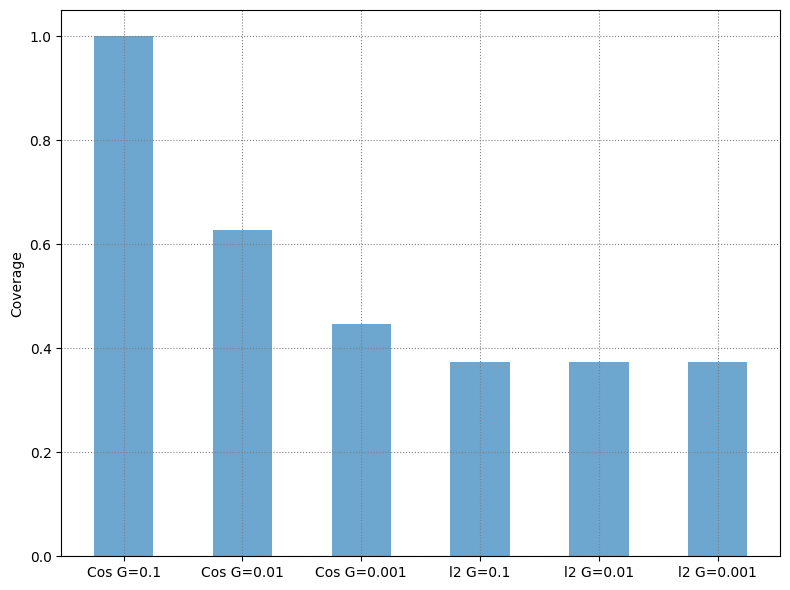

In [105]:
plot_bar_chart(
    data={
        "Cos G=0.1": data_cos["coverages"][0.1],
        "Cos G=0.01": data_cos["coverages"][0.01],
        "Cos G=0.001": data_cos["coverages"][0.001],
        "l2 G=0.1": data_l2["coverages"][0.1],
        "l2 G=0.01": data_l2["coverages"][0.01],
        "l2 G=0.001": data_l2["coverages"][0.001],
    },
    x_label="",
    y_label="Coverage",
    img_path="coverages_gamma.png",
)

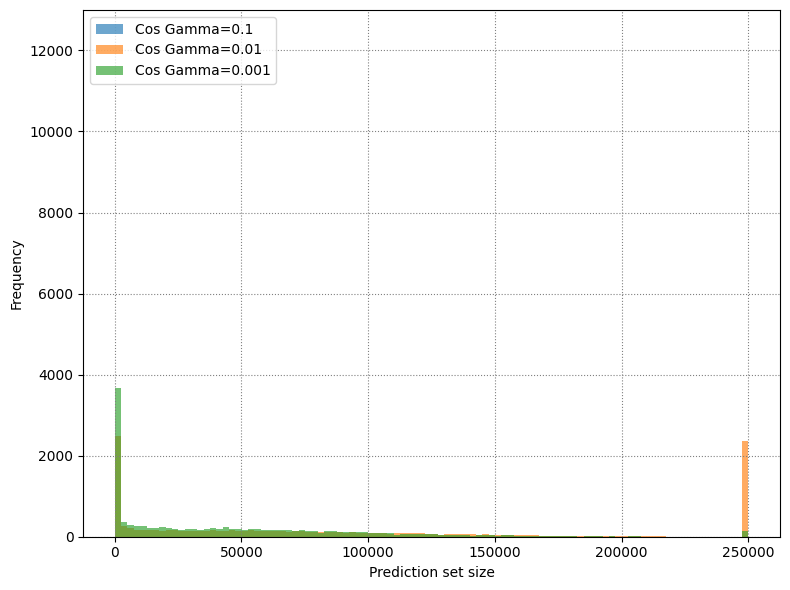

Cos Gamma=0.1 | Mean: 250054.00 | Median: 250054.0 | Std: 0.00
Cos Gamma=0.01 | Mean: 90720.62 | Median: 61612.0 | Std: 90484.70
Cos Gamma=0.001 | Mean: 44027.63 | Median: 28745.5 | Std: 50118.74


In [143]:
cos_data = {
    "Cos Gamma=0.1": data_cos["pred_set_sizes"][0.1],
    "Cos Gamma=0.01": data_cos["pred_set_sizes"][0.01],
    "Cos Gamma=0.001": data_cos["pred_set_sizes"][0.001],
}

plot_histogram(
    data=cos_data,
    xlabel="Prediction set size",
    num_bins=100,
    img_path="pred_set_sizes_cos_gamma.png"
)

for name, sizes in cos_data.items():
    print(f"{name} | Mean: {np.mean(sizes):.2f} | Median: {np.median(sizes)} | Std: {np.std(sizes):.2f}")

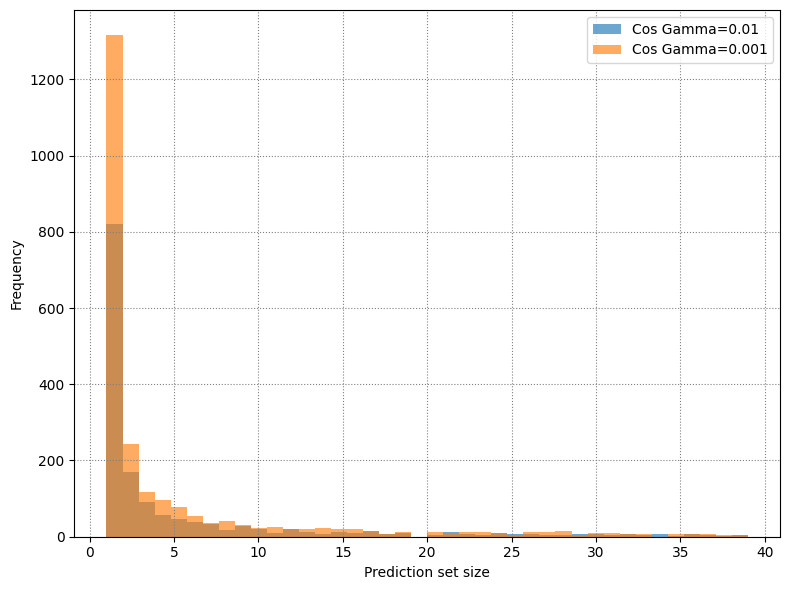

In [153]:
zoom = lambda lst: list(filter(lambda val: val < 40, lst))

cos_data = {
    #"Cos Gamma=0.1": zoom(data_cos["pred_set_sizes"][0.1]),
    "Cos Gamma=0.01": zoom(data_cos["pred_set_sizes"][0.01]),
    "Cos Gamma=0.001": zoom(data_cos["pred_set_sizes"][0.001]),
}

plot_histogram(
    data=cos_data,
    xlabel="Prediction set size",
    num_bins=40,
    img_path="pred_set_sizes_cos_gamma_zoom.png"
)


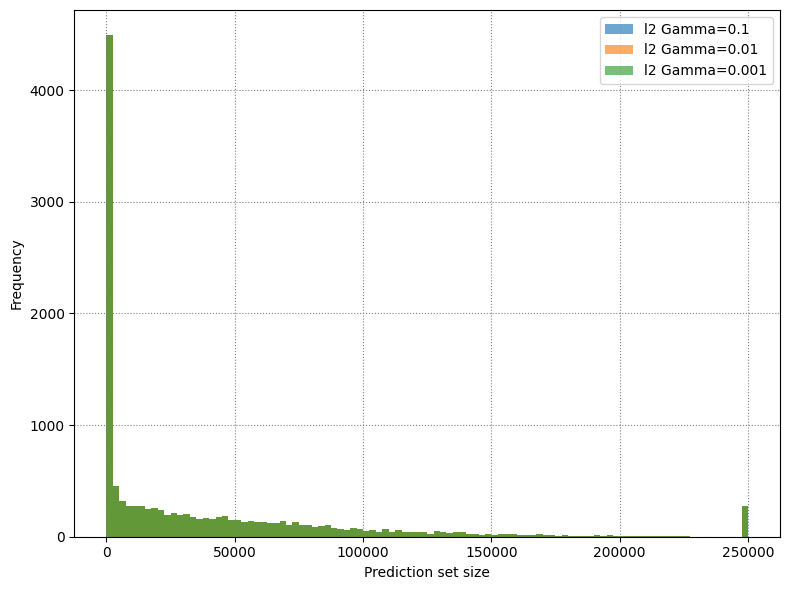

l2 Gamma=0.1 | Mean: 38436.55 | Median: 16048.0 | Std: 53418.28
l2 Gamma=0.01 | Mean: 38436.55 | Median: 16048.0 | Std: 53418.28
l2 Gamma=0.001 | Mean: 38436.55 | Median: 16048.0 | Std: 53418.28


In [119]:
l2_data = {
    "l2 Gamma=0.1": data_l2["pred_set_sizes"][0.1],
    "l2 Gamma=0.01": data_l2["pred_set_sizes"][0.01],
    "l2 Gamma=0.001": data_l2["pred_set_sizes"][0.001],
}

plot_histogram(
    data={
        "l2 Gamma=0.1": data_l2["pred_set_sizes"][0.1],
        "l2 Gamma=0.01": data_l2["pred_set_sizes"][0.01],
        "l2 Gamma=0.001": data_l2["pred_set_sizes"][0.001],
    },
    xlabel="Prediction set size",
    num_bins=100,
    img_path="pred_set_sizes_l2_gamma.png"
)

for name, sizes in l2_data.items():
    print(f"{name} | Mean: {np.mean(sizes):.2f} | Median: {np.median(sizes)} | Std: {np.std(sizes):.2f}")

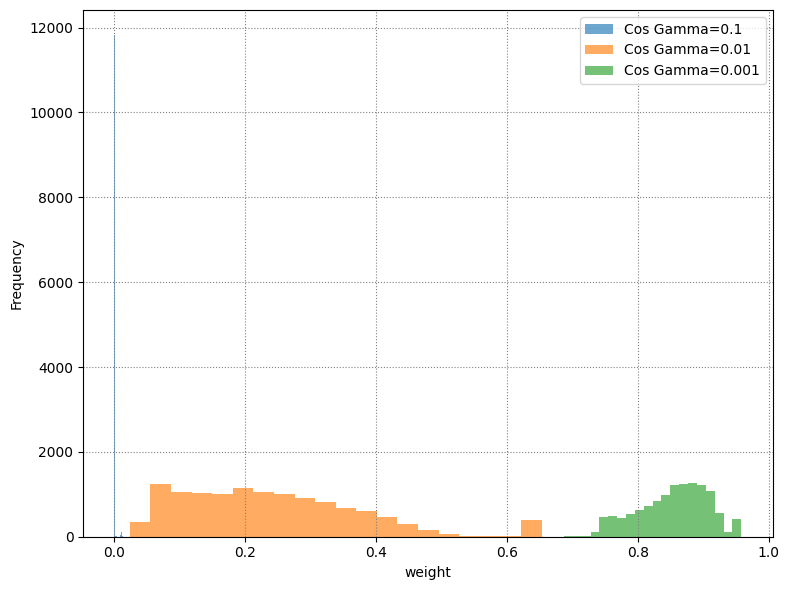

In [90]:
plot_histogram(
    data={
        "Cos Gamma=0.1": data_cos["weights"][0.1],
        "Cos Gamma=0.01": data_cos["weights"][0.01],
        "Cos Gamma=0.001": data_cos["weights"][0.001],
    },
    xlabel="weight",
    num_bins=20,
    img_path="weights_cos_gamma.png"
)

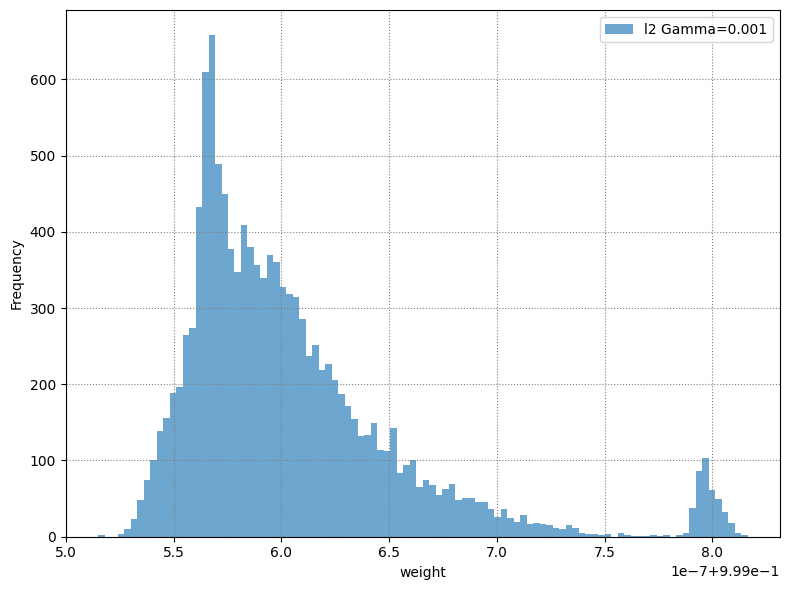

In [91]:
plot_histogram(
    data={
        #"l2 Gamma=0.1": data_l2["weights"][0.1],
        #"l2 Gamma=0.01": data_l2["weights"][0.01],
        "l2 Gamma=0.001": data_l2["weights"][0.001],
    },
    xlabel="weight",
    num_bins=100,
    img_path="weights_gamma0001_l2.png"
)

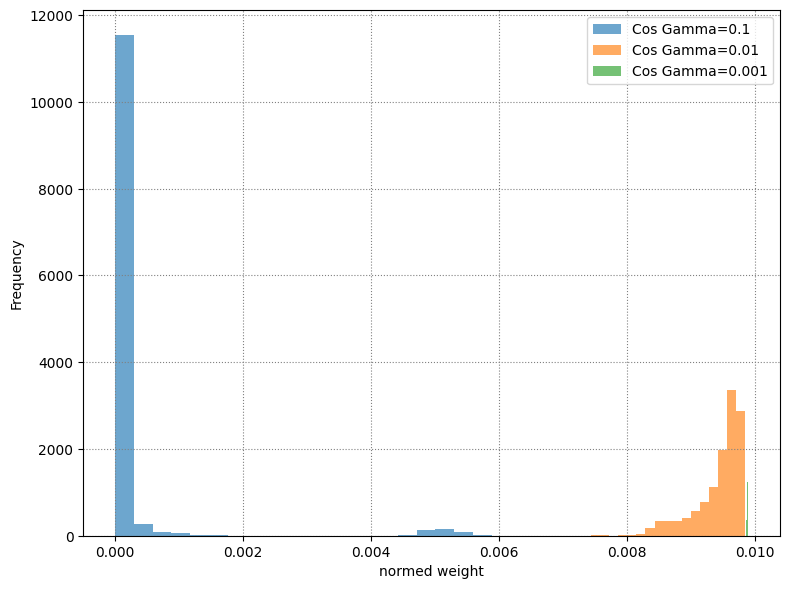

In [108]:
plot_histogram(
    data={
        "Cos Gamma=0.1": data_cos["normed_weights"][0.1],
        "Cos Gamma=0.01": data_cos["normed_weights"][0.01],
        "Cos Gamma=0.001": data_cos["normed_weights"][0.001],
    },
    xlabel="normed weight",
    num_bins=20,
    img_path="normed_weights_cos_gamma.png"
)

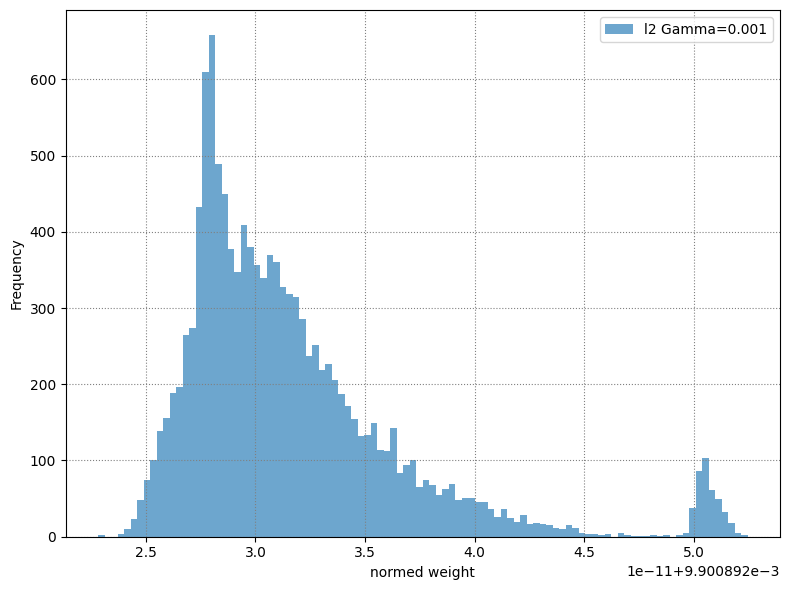

In [109]:
plot_histogram(
    data={
        #"l2 Gamma=0.1": data_l2["weights"][0.1],
        #"l2 Gamma=0.01": data_l2["weights"][0.01],
        "l2 Gamma=0.001": data_l2["normed_weights"][0.001],
    },
    xlabel="normed weight",
    num_bins=100,
    img_path="normed_weights_gamma0001_l2.png"
)

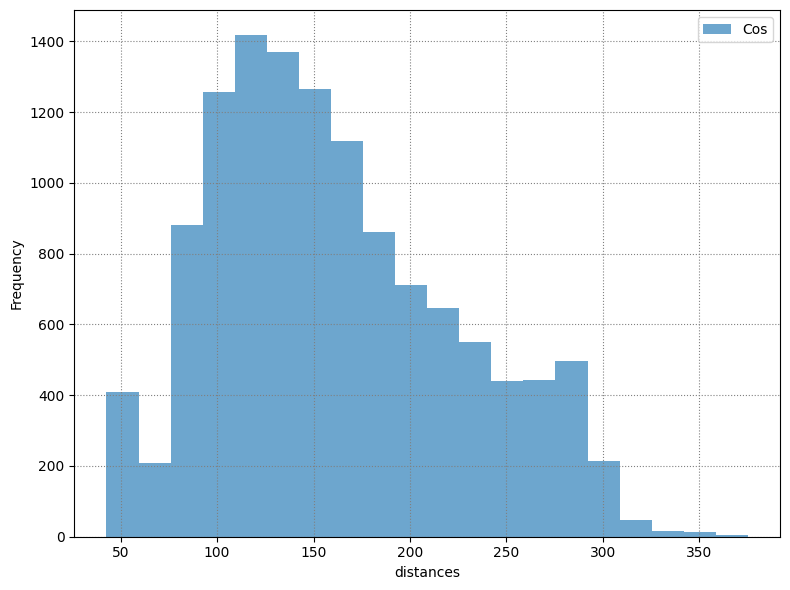

In [121]:
plot_histogram(
    data={
        "Cos": data_cos["distances"],
    },
    xlabel="distances",
    num_bins=20,
    img_path="distances_cos_gamma.png"
)

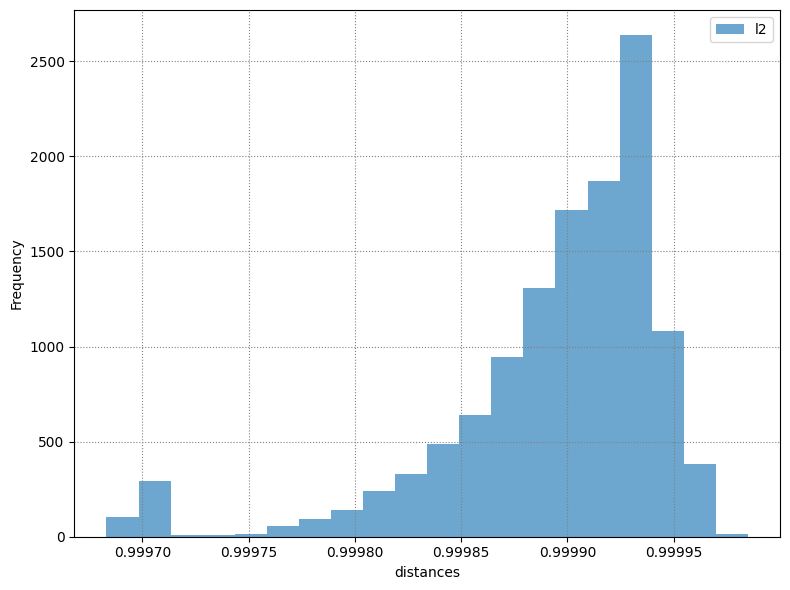

In [122]:
plot_histogram(
    data={
        "l2": data_l2["distances"],
    },
    xlabel="distances",
    num_bins=20,
    img_path="distances_l2_gamma.png"
)

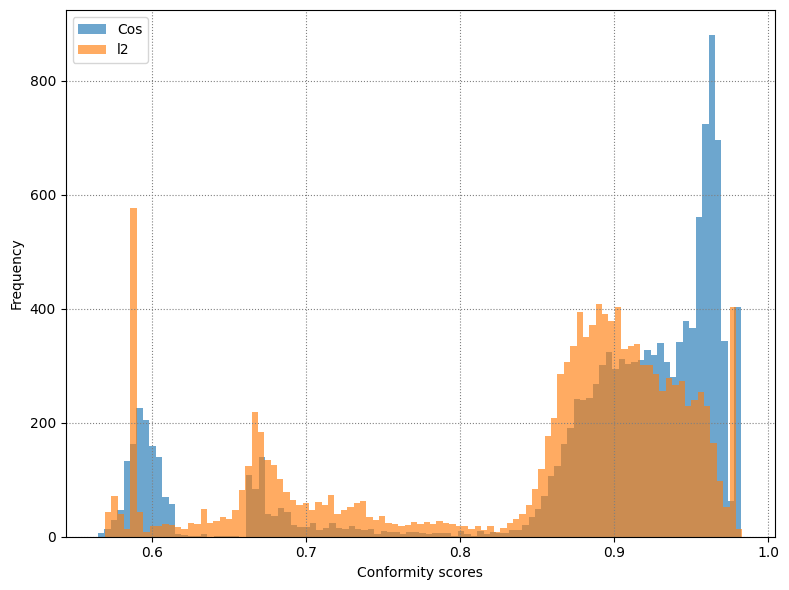

In [141]:
plot_histogram(
    data={
        "Cos": data_cos["conformity_scores"],
        "l2": data_l2["conformity_scores"],
    },
    xlabel="Conformity scores",
    num_bins=100,
    img_path="conformity_scores_gamma.png"
)

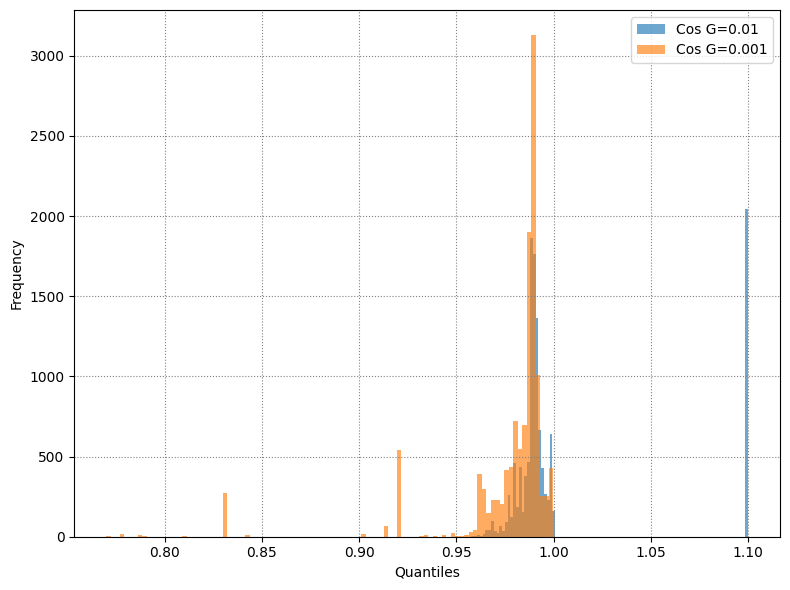

In [139]:
def replace_inf(arr):
    arr = np.array(arr)
    arr[np.isinf(arr)] = 1.1
    
    return arr

plot_histogram(
    data={
        #"Cos G=0.1": replace_inf(data_cos["quantiles"][0.1]),
        "Cos G=0.01": replace_inf(data_cos["quantiles"][0.01]),
        "Cos G=0.001": replace_inf(data_cos["quantiles"][0.001]),
    },
    xlabel="Quantiles",
    num_bins=100,
    img_path="quantiles_cos_gamma.png"
)

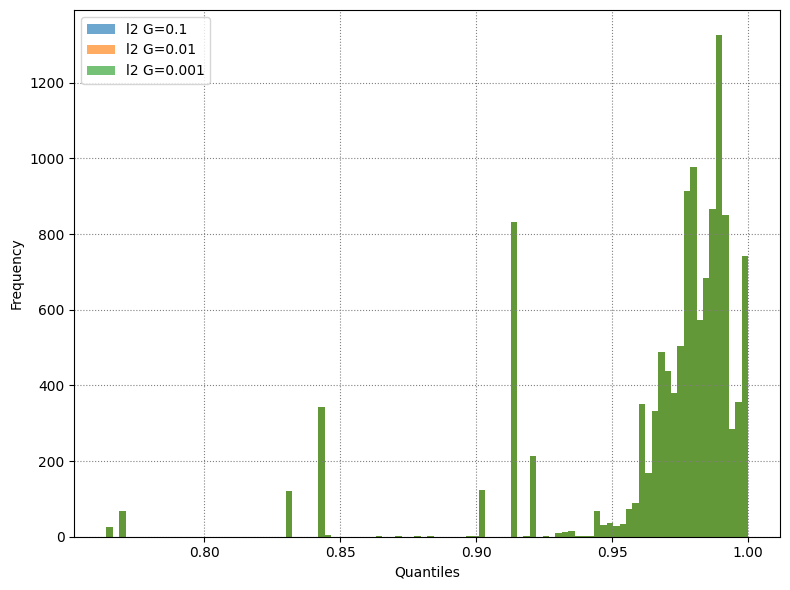

In [138]:
plot_histogram(
    data={
        "l2 G=0.1": replace_inf(data_l2["quantiles"][0.1]),
        "l2 G=0.01": replace_inf(data_l2["quantiles"][0.01]),
        "l2 G=0.001": replace_inf(data_l2["quantiles"][0.001]),
    },
    xlabel="Quantiles",
    num_bins=100,
    img_path="quantiles_l2_gamma.png"
)

## Code dump (maybe just later)

In [ ]:
def get_coverage_likelihood(prediction_sets, labels, exp_coverage):
    covered = np.array(list(map(
        lambda tpl: int(int(tpl[1].numpy()) in tpl[0]), 
        zip(prediction_sets, labels)
    )))
    
    likelihoods = covered * np.log(exp_coverage) + (1 - covered) * np.log(1 - exp_coverage)
    
    return np.sum(likelihoods)

In [ ]:
get_coverage_likelihood(all_test_pred_sets, all_test_labels, np.ones(len(all_test_pred_sets)) * (1 - ALPHA))

In [ ]:
get_coverage_likelihood(all_test_pred_sets, all_test_labels, np.max(1 - ALPHA - np.array(coverage_gaps), 0))

## Sanity Check: Evaluation 

In [28]:
def create_translations(model, sources, tokenizer, target_path):
    # Tokenize inputs and feed to model
    generation_config = transformers.GenerationConfig.from_pretrained(mbart_model)
    generation_config.decoder_hidden_states = False
    generation_config.return_dict_in_generate = False
    generation_config.num_beams = 4
    #print(generation_config)

    with codecs.open(target_path, "w", "utf-8") as target_file:
        for sent in tqdm(sources):    
            tokenized_sequences = tokenizer(sent, return_tensors="pt", padding=True)

            outputs = model.generate(
                input_ids=tokenized_sequences["input_ids"], 
                attention_mask=tokenized_sequences["attention_mask"],
                forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"],
                generation_config=generation_config,
            )

            decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True, clean_up_tokenization_spaces=True)

            target_file.write(decoded[0] + "\n")

In [18]:
def write_references(references, ref_path):
    with codecs.open(ref_path, "w", "utf-8") as ref_file:
        for ref in references:
            ref_file.write(ref + "\n")

In [16]:
write_references(test_target, "references.txt")

In [31]:
write_references(test_source, "source.txt")

In [29]:
create_translations(model, test_source, tokenizer, "translations.txt")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [1:06:49<00:00, 10.05s/it]


* BLEU: 16.6456,
* ChrF: 45.3930,
* TER: 77.3250
* COMET22: 0.7871